# Pre-processing Allocation data for WaDE upload.
- Purpose:  To pre-process the data into one main file for simple DataFrame creation and extraction

In [1]:
import os
import sys
print(os.environ['CONDA_DEFAULT_ENV'])
print(sys.version)

base
3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]


In [2]:
# Needed Libraries / Modules

# ---- working with data ----
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [3]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/WaDE Data Folder/Montana/WaterAllocation" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/WaDE Data Folder/Montana/WaterAllocation


## Point of Diversion Data

In [4]:
# Input File
FI_PoD = "RawInputData/PointsOfDiversion.zip"
dfinPOD = pd.read_csv(FI_PoD).replace(np.nan, "")

# WaDE UUID tracker for data assessment
if 'WaDEUUID' not in dfinPOD:
    dfinPOD['WaDEUUID'] = "d" + dfinPOD.index.astype(str)
    dfinPOD.to_csv('RawInputData/PointsOfDiversion.zip', compression=dict(method='zip', archive_name='PointsOfDiversion.csv'), index=False)

print(len(dfinPOD))
dfinPOD.head(1)

546247


,WRGT_ID_SEQ,BOCA_CD,WTR_ID,WR_NUMBER,WR_TYPE,WR_STATUS,VERS,VERS_TYPE,ENF_PRTY_DT_DATE,ENF_PRTY_DT_CHAR,APPLICATION_ISSUE_DT,OWNERS,PURPOSES,GEOCODES,PODV_ID_SEQ,PODV_NO,SOURCE_TYPE,SOURCE_NAME,MEANS_OF_DIV,DITCH,WELL_DEPTH,PERIOD_OF_DIVERSIONS,COUNTY,STATE,TRSS_ID_SEQ,TWP_RNG,SCTN,LLDS_ID_SEQ,Q,QQQQ,GOVT_LOT,SPX,SPY,WRKEY,REFRESH_DATE,URL_ABSTRACT,URL_SCAN,TRS_QQQQ,MAX_FLOW,MAX_VOL,MAX_ACRES,MAX_FLOW_RT,FLOW_RT_UNIT,MAX_FLOW_GPM,MAX_FLOW_CFS,Longitude,Latitude,HIST_TYPE,AUM_SUM,WaDEUUID
0,100325,76N,52615,76N 52615 00,STATEMENT OF CLAIM,ACTIVE,3,POST DECREE,6/1/1915 6:00:00,1915/06/01,,USA (DEPT OF AGRICULTURE FOREST SERVICE),STOCK,,1103879,2,SURFACE,FISHTRAP CREEK,LIVESTOCK DIRECT FROM SOURCE,,,06/01 to 09/30,SANDERS,MT,148077.00000,25N28W,22.00000,547339.00000,,,,,,100325-3,4/4/2025 7:10:21,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,https://dnrwaterrightdocuments.mt.gov/execute-...,T25N R28W Sec. 22,,,,,,,,-115.19375,47.90917,USE,125.00000,d0


In [5]:
# separate out PERIOD_OF_DIVERSIONS to start date
def SeparatePERIODOFDIVERSIONSStartFunc(val):
    val = str(val).strip()
    if val == "" or val == " " or val == "nan" or pd.isnull(val):
        outString = ""
    else:
        if ";" in val:
            val = val.split(";")[0].strip()
        outString = val.split("to")[0].strip()
    return outString

dfinPOD['in_AllocationTimeframeStart'] = dfinPOD.apply(lambda row: SeparatePERIODOFDIVERSIONSStartFunc(row['PERIOD_OF_DIVERSIONS']), axis=1)
dfinPOD['in_AllocationTimeframeStart'].unique()

array(['06/01', '01/01', '', '05/01', '04/01', '12/01', '03/01', '07/01',
       '02/01', '08/01', '11/01', '09/01', '10/01', '03/15', '04/15',
       '02/15', '04/10', '07/16', '06/16', '05/16', '05/15', '04/30',
       '04/16', '07/15', '07/21', '11/30', '05/31', '06/15', '06/28',
       '05/21', '05/11', '10/15', '09/15', '06/30', '06/20', '04/20',
       '11/15', '06/23', '06/10', '06/11', '05/10', '01/28', '05/03',
       '06/21', '05/25', '10/10', '04/25', '08/15', '04/28', '02/29',
       '03/05', '03/25', '03/31', '06/25', '04/05', '09/25', '05/20',
       '02/10', '03/20', '07/31', '11/10', '12/31', '09/30', '03/30',
       '05/04', '11/20', '03/10', '09/20', '01/31', '01/15', '07/05',
       '05/28', '04/02', '06/05', '08/20', '05/05', '09/21', '02/28',
       '12/15', '10/16', '10/31', '07/26', '11/16', '05/30', '01/10',
       '11/25', '10/20', '04/18', '03/28', '07/25', '05/27', '08/25',
       '01/05', '04/04', '10/05', '07/10', '09/10', '08/31', '05/22',
       '07/04', 

In [6]:
# separate out PERIOD_OF_DIVERSIONS to end date
def SeparatePERIODOFDIVERSIONSEndFunc(val):
    val = str(val).strip()
    if val == "" or val == " " or val == "nan" or pd.isnull(val):
        outString = ""
    else:
        if ";" in val:
            val = val.split(";")[0].strip()
        outString = val.split("to")[1].strip()
    return outString

dfinPOD['in_AllocationTimeframeEnd'] = dfinPOD.apply(lambda row: SeparatePERIODOFDIVERSIONSEndFunc(row['PERIOD_OF_DIVERSIONS']), axis=1)
dfinPOD['in_AllocationTimeframeEnd'].unique()

array(['09/30', '12/31', '', '11/30', '03/31', '12/15', '01/31', '07/31',
       '02/28', '10/19', '08/31', '06/30', '05/31', '04/30', '10/31',
       '05/15', '12/01', '10/01', '11/15', '11/01', '10/15', '11/24',
       '07/20', '03/30', '07/15', '06/15', '04/15', '05/04', '04/19',
       '08/04', '07/19', '11/19', '05/01', '10/04', '12/04', '11/04',
       '07/07', '01/01', '10/09', '08/15', '02/24', '09/04', '05/20',
       '03/15', '07/01', '06/01', '06/27', '05/10', '04/01', '02/01',
       '09/10', '09/19', '10/10', '10/08', '09/01', '09/15', '09/20',
       '10/30', '01/15', '09/23', '12/30', '06/10', '11/29', '06/20',
       '07/04', '10/05', '10/14', '08/19', '08/20', '12/20', '02/29',
       '03/01', '06/29', '06/04', '05/28', '05/19', '05/29', '12/24',
       '09/25', '11/14', '02/15', '10/25', '08/01', '01/25', '01/30',
       '12/10', '12/13', '10/29', '01/04', '01/19', '09/28', '09/05',
       '10/20', '10/24', '10/03', '08/30', '07/10', '11/10', '05/24',
       '12/21', 

In [7]:
# convert and round MAX_FLOW
def ConvertMAXFLOWFunc(val):
    val = str(val).strip()
    if val == "CFS" or val == "GPM" or val == "POF" or val == "" or val == " " or val == "nan" or pd.isnull(val):
        outVal = ""
    else:
        if "CFS" in val:
            val = val.split(" ")[0].strip()
            outVal = float(val)
        elif "GPM" in val:
            val = val.split(" ")[0].strip()
            outVal = (float(val) * 0.0026757275153786)
        elif "POF" in val:
            outVal = ""
        else:
            outVal = float(val)
    return outVal

dfinPOD['MAX_FLOW'] = dfinPOD.apply(lambda row: ConvertMAXFLOWFunc(row['MAX_FLOW']), axis=1)
dfinPOD['MAX_FLOW'].unique()

array(['', 0.26757275153786003, 0.0321087301845432, ..., 14.56,
       0.014823530435197445, 0.04016267000583279], dtype=object)

In [8]:
# create output POD dataframe
df = pd.DataFrame()

# Data Assessment UUID
df['WaDEUUID'] = dfinPOD['WaDEUUID']

# Method Info
df['in_MethodUUID'] = "MTwr_M1"

# Variable Info
df['in_VariableSpecificUUID'] = "MTwr_V1"

# Organization Info
df['in_OrganizationUUID'] = "MTwr_O1"

# WaterSource Info
df['in_Geometry'] = ""
df['in_GNISFeatureNameCV'] = ""
df['in_WaterQualityIndicatorCV'] = "Fresh"
df['in_WaterSourceName'] = dfinPOD['SOURCE_NAME']
df['in_WaterSourceNativeID'] = "" # auto fill in below if not provdied
df['in_WaterSourceTypeCV'] = dfinPOD['SOURCE_TYPE']

# Site Info
df['in_CoordinateAccuracy'] = "WaDE Blank"
df['in_CoordinateMethodCV'] = "WaDE Blank"
df['in_County'] = dfinPOD['COUNTY']
df['in_EPSGCodeCV'] = "4326"
df['in_Geometry'] = ""
df['in_GNISCodeCV'] = ""
df['in_HUC12'] = ""
df['in_HUC8'] = ""
df['in_Latitude'] = dfinPOD['Latitude']
df['in_Longitude'] = dfinPOD['Longitude']
df['in_NHDNetworkStatusCV'] = ""
df['in_NHDProductCV'] = ""
df['in_PODorPOUSite'] = "POD"  # "Point of Diversion"
df['in_SiteName'] = ""
df['in_SiteNativeID'] = "d" + dfinPOD['PODV_NO'].astype(str).str.strip() + "_" + dfinPOD['WR_NUMBER'].astype(str).str.strip()
df['in_SitePoint'] = ""
df['in_SiteTypeCV'] = dfinPOD['MEANS_OF_DIV']
df['in_StateCV'] = "MT"
df['in_USGSSiteID'] = ""

# AllocationAmount Info
df['in_AllocationApplicationDate'] = ""
df['in_AllocationAssociatedConsumptiveUseSiteIDs'] = ""
df['in_AllocationAssociatedWithdrawalSiteIDs'] = ""
df['in_AllocationBasisCV'] = ""
df['in_AllocationChangeApplicationIndicator'] = ""
df['in_AllocationCommunityWaterSupplySystem'] = ""
df['in_AllocationCropDutyAmount'] = ""
df['in_AllocationExpirationDate'] = ""
df['in_AllocationFlow_CFS'] = dfinPOD['MAX_FLOW']
df['in_AllocationLegalStatusCV'] = dfinPOD['WR_STATUS']
df['in_AllocationNativeID'] = dfinPOD['WR_NUMBER']
df['in_AllocationOwner'] = dfinPOD['OWNERS']
df['in_AllocationPriorityDate'] = dfinPOD['ENF_PRTY_DT_DATE']
df['in_AllocationSDWISIdentifierCV'] = ""
df['in_AllocationTimeframeEnd'] = dfinPOD['in_AllocationTimeframeEnd']
df['in_AllocationTimeframeStart'] = dfinPOD['in_AllocationTimeframeStart']
df['in_AllocationTypeCV'] = dfinPOD['WR_TYPE']
df['in_AllocationVolume_AF'] = dfinPOD['MAX_VOL']
df['in_BeneficialUseCategory'] = dfinPOD['PURPOSES']
df['in_CommunityWaterSupplySystem'] = ""
df['in_CropTypeCV'] = ""
df['in_CustomerTypeCV'] = ""
df['in_DataPublicationDate'] = ""
df['in_DataPublicationDOI'] = ""
df['in_ExemptOfVolumeFlowPriority'] = "0" # either a 1 or 0
df['in_GeneratedPowerCapacityMW'] = ""
df['in_IrrigatedAcreage'] = dfinPOD['MAX_ACRES']
df['in_IrrigationMethodCV'] = ""
df['in_LegacyAllocationIDs'] = ""
df['in_OwnerClassificationCV'] = ""
df['in_PopulationServed'] = ""
df['in_PowerType'] = ""
df['in_PrimaryBeneficialUseCategory'] = ""
df['in_SDWISIdentifierCV'] = ""
df['in_WaterAllocationNativeURL'] = dfinPOD['URL_ABSTRACT']
outPOD = df.copy()
outPOD = outPOD.drop_duplicates().reset_index(drop=True)
print(len(outPOD))
outPOD.head()

546247


,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL
0,d0,MTwr_M1,MTwr_V1,MTwr_O1,,,Fresh,FISHTRAP CREEK,,SURFACE,WaDE Blank,WaDE Blank,SANDERS,4326,,,,47.90917,-115.19375,,,POD,,d2_76N 52615 00,,LIVESTOCK DIRECT FROM SOURCE,MT,,,,,,,,,,,ACTIVE,76N 52615 00,USA (DEPT OF AGRICULTURE FOREST SERVICE),6/1/1915 6:00:00,,09/30,06/01,STATEMENT OF CLAIM,,STOCK,,,,,,0,,,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
1,d1,MTwr_M1,MTwr_V1,MTwr_O1,,,Fresh,GROUNDWATER,,GROUNDWATER,WaDE Blank,WaDE Blank,LAKE,4326,,,,47.66730,-114.10262,,,POD,,d1_76LJ 30161212,,INDIVIDUAL WELL,MT,,,,,,,,,,0.26757,ACTIVE,76LJ 30161212,ALVIN DEVORE; BARBARA DEVORE,8/21/2023 19:33:00,,12/31,01/01,DOMESTIC ALLOWANCE,,LAWN AND GARDEN; DOMESTIC,,,,,,0,,0.50000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
2,d2,MTwr_M1,MTwr_V1,MTwr_O1,,,Fresh,GROUNDWATER,,GROUNDWATER,WaDE Blank,WaDE Blank,LAKE,4326,,,,47.63843,-114.20987,,,POD,,d1_76L 30160191,,INDIVIDUAL WELL,MT,,,,,,,,,,0.03211,ACTIVE,76L 30160191,JOHN B KING; MARY E KING,2/2/2023 17:20:00,,12/31,01/01,DOMESTIC ALLOWANCE,,LAWN AND GARDEN; DOMESTIC,,,,,,0,,0.25000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
3,d3,MTwr_M1,MTwr_V1,MTwr_O1,,,Fresh,UNNAMED TRIBUTARY OF DUBLIN GULCH,,SURFACE,WaDE Blank,WaDE Blank,LAKE,4326,,,,47.46435,-114.12911,,,POD,,d7_76L 30144554,,LIVESTOCK DIRECT FROM SOURCE,MT,,,,,,,,,,,ACTIVE,76L 30144554,"MONTANA, STATE OF DEPT OF FISH WILDLIFE & PARKS",3/21/1934 6:00:00,,12/31,01/01,STATEMENT OF CLAIM,,STOCK,,,,,,0,,,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
4,d4,MTwr_M1,MTwr_V1,MTwr_O1,,,Fresh,UNNAMED TRIBUTARY OF DUBLIN GULCH,,SURFACE,WaDE Blank,WaDE Blank,LAKE,4326,,,,47.46433,-114.10775,,,POD,,d6_76L 30144554,,LIVESTOCK DIRECT FROM SOURCE,MT,,,,,,,,,,,ACTIVE,76L 30144554,"MONTANA, STATE OF DEPT OF FISH WILDLIFE & PARKS",3/21/1934 6:00:00,,12/31,01/01,STATEMENT OF CLAIM,,STOCK,,,,,,0,,,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...


## Place of Use Data

In [9]:
# Input File - place of use data
FI_POU = "RawInputData/shapefiles/PlacesofUse.zip"
dfinPOU = gpd.read_file(FI_POU).replace(np.nan, "")
dfinPOU['geometry'] = dfinPOU['geometry'].to_crs(epsg=4326) # Realign Geometry Projection

# WaDE UUID tracker for data assessment
if 'WaDEUUID' not in dfinPOU:
    dfinPOU['WaDEUUID'] = "u" + dfinPOU.index.astype(str)
    dfinPOU.to_csv('RawInputData/PlacesofUse.zip', compression=dict(method='zip', archive_name='PlacesofUse.csv'), index=False)

print(len(dfinPOU))
dfinPOU.head(1)

955710


,WRGT_ID_SE,BOCA_CD,WTR_ID,WR_NUMBER,WR_TYPE,WR_STATUS,VERS,VERS_TYPE,ENF_PRTY_D,ENF_PRTY_1,APPLICATIO,OWNERS,PURPOSES,GEOCODES,PURS_ID_SE,PURT_CD,PURPOSE,IRR_TYPE,AUM,PERIOD_OF_,POU_NO,ACREAGE,COUNTY,STATE,TRSS_ID_SE,TWP_RNG,SCTN,LLDS_ID_SE,Q,QQQQ,GOVT_LOT,WRKEY,REFRESH_DA,URL_ABSTRA,URL_SCAN,TRS_QQQQ,MAX_FLOW,MAX_VOL,MAX_ACRES,MAX_FLOW_R,FLOW_RT_UN,MAX_FLOW_G,MAX_FLOW_C,HIST_TYPE,AUM_SUM,cent_Longi,cent_Latit,Shape_Leng,Shape_Area,geometry,WaDEUUID
0,204777,76N,116396,76N 116396 00,STATEMENT OF CLAIM,ACTIVE,2,REEXAMINED,1955/12/31,1955/12/31,NaT,"MONTANA, STATE OF DEPT OF FISH WILDLIFE & PARK...",FIRE PROTECTION,,709174,FP,FIRE PROTECTION,,0.00000,04-01 to 10-31,57,0.00000,SANDERS,MT,148113,25N26W,30,547375,,,,204777-2,2025-04-04,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,https://dnrwaterrightdocuments.mt.gov/execute-...,T25N R26W Sec. 30,50 GPM,0.00000,0.00000,50.00000,GPM,50.00000,0.11140,USE,0.00000,-114.99992,47.89452,0.07118,0.00031,"POLYGON ((-115.01046 47.88724, -115.01046 47.8...",u0


In [10]:
# separate out PERIOD_OF_DIVERSIONS to start date

# replace "-" char with a "/" char to match POD data
dfinPOU['PERIOD_OF_'] = dfinPOU['PERIOD_OF_'].str.replace("-", "/").str.replace(";", ",")

def SeparatePERIODOFDIVERSIONSStartFunc(val):
    val = str(val).strip()
    if val == "" or val == " " or val == "nan" or pd.isnull(val):
        outString = ""
    else:
        if ";" in val:
            val = val.split(";")[0].strip()
        outString = val.split("to")[0].strip()
    return outString

dfinPOU['in_AllocationTimeframeStart'] = dfinPOU.apply(lambda row: SeparatePERIODOFDIVERSIONSStartFunc(row['PERIOD_OF_']), axis=1)
dfinPOU['in_AllocationTimeframeStart'].unique()

array(['04/01', '05/01', '01/01', '04/15', '04/10', '07/15', '06/15',
       '05/15', '03/01', '09/01', '04/28', '', '03/15', '03/23', '04/20',
       '07/16', '07/01', '06/16', '05/16', '04/30', '04/16', '05/10',
       '08/01', '10/01', '06/01', '02/15', '10/11', '04/25', '02/01',
       '11/01', '04/14', '12/01', '07/20', '03/10', '03/20', '11/30',
       '06/28', '10/20', '10/15', '05/31', '05/20', '09/15', '05/25',
       '05/28', '12/15', '06/30', '12/31', '06/23', '06/11', '05/11',
       '02/29', '11/15', '05/03', '01/07', '05/02', '03/31', '08/15',
       '08/28', '12/28', '01/15', '04/05', '09/07', '05/05', '03/25',
       '01/20', '06/05', '03/28', '09/30', '03/05', '02/10', '11/28',
       '06/10', '07/31', '03/30', '01/31', '09/20', '06/25', '10/31',
       '10/05', '07/10', '10/06', '08/20', '09/21', '08/06', '06/06',
       '07/26', '04/18', '05/30', '07/25', '11/25', '06/20', '10/25',
       '01/10', '02/05', '02/20', '11/10', '08/31', '09/25', '07/04',
       '08/25', 

In [11]:
# separate out PERIOD_OF_DIVERSIONS to end date
def SeparatePERIODOFDIVERSIONSEndFunc(val):
    val = str(val).strip()
    if val == "" or val == " " or val == "nan" or pd.isnull(val):
        outString = ""
    else:
        if ";" in val:
            val = val.split(";")[0].strip()
        outString = val.split("to")[1].strip()
    return outString

dfinPOU['in_AllocationTimeframeEnd'] = dfinPOU.apply(lambda row: SeparatePERIODOFDIVERSIONSEndFunc(row['PERIOD_OF_']), axis=1)
dfinPOU['in_AllocationTimeframeEnd'].unique()

array(['10/31', '10/01', '11/01', '12/31', '10/15', '12/15', '11/30',
       '09/15', '10/04', '09/30', '10/19', '09/01', '12/01', '11/19',
       '11/04', '01/04', '08/04', '07/31', '05/31', '10/30', '12/04',
       '11/15', '08/30', '', '01/01', '12/31, 01/01', '11/22', '11/24',
       '10/20', '10/14', '08/31', '07/15', '06/30', '06/15', '04/30',
       '03/31', '05/15', '05/04', '04/19', '07/19', '10/10', '04/15',
       '09/04', '10/09', '01/31', '11/10', '11/20', '08/15', '03/15',
       '11/02', '06/27', '11/20, 05/15', '06/01', '07/01', '07/20',
       '06/10, 06/25', '12/15, 05/15', '02/01', '09/10', '04/01', '08/01',
       '05/01', '03/01', '12/30', '09/19', '10/08', '07/30', '11/14',
       '06/11', '08/19', '12/19', '12/10', '10/31, 04/01', '10/24',
       '10/05', '01/15', '09/23', '11/07', '10/02', '06/04',
       '09/30, 04/01', '05/19', '09/14', '10/29', '11/29', '07/04',
       '09/20', '08/10', '10/15, 04/15', '08/24', '09/25', '03/30',
       '05/20', '07/10', '07/2

In [12]:
# convert and round MAX_FLOW
def ConvertMAXFLOWFunc(val):
    val = str(val).strip()
    if val == "CFS" or val == "GPM" or val == "POF" or val == "" or val == " " or val == "nan" or pd.isnull(val):
        outVal = ""
    else:
        if "CFS" in val:
            val = val.split(" ")[0].strip()
            outVal = float(val)
        elif "GPM" in val:
            val = val.split(" ")[0].strip()
            outVal = (float(val) * 0.0026757275153786)
        elif "POF" in val:
            outVal = ""
        else:
            outVal = float(val)
    return outVal

dfinPOU['MAX_FLOW'] = dfinPOU.apply(lambda row: ConvertMAXFLOWFunc(row['MAX_FLOW']), axis=1)
dfinPOU['MAX_FLOW'].unique()

array([0.13378637576893002, 1.0702910061514401, 2.1405820123028803, ...,
       0.07807772889874755, 0.13022765817347648, 0.0030503293675316037],
      dtype=object)

In [13]:
# Left-join outPOD to ensure water source information matches POD records

dfinPOU = pd.merge(dfinPOU, outPOD[['in_AllocationNativeID', 'in_WaterSourceName', 'in_WaterSourceTypeCV']], left_on='WR_NUMBER', right_on='in_AllocationNativeID', how='left')
print(len(dfinPOU))
dfinPOU.head(1)

2691944


,WRGT_ID_SE,BOCA_CD,WTR_ID,WR_NUMBER,WR_TYPE,WR_STATUS,VERS,VERS_TYPE,ENF_PRTY_D,ENF_PRTY_1,APPLICATIO,OWNERS,PURPOSES,GEOCODES,PURS_ID_SE,PURT_CD,PURPOSE,IRR_TYPE,AUM,PERIOD_OF_,POU_NO,ACREAGE,COUNTY,STATE,TRSS_ID_SE,TWP_RNG,SCTN,LLDS_ID_SE,Q,QQQQ,GOVT_LOT,WRKEY,REFRESH_DA,URL_ABSTRA,URL_SCAN,TRS_QQQQ,MAX_FLOW,MAX_VOL,MAX_ACRES,MAX_FLOW_R,FLOW_RT_UN,MAX_FLOW_G,MAX_FLOW_C,HIST_TYPE,AUM_SUM,cent_Longi,cent_Latit,Shape_Leng,Shape_Area,geometry,WaDEUUID,in_AllocationTimeframeStart,in_AllocationTimeframeEnd,in_AllocationNativeID,in_WaterSourceName,in_WaterSourceTypeCV
0,204777,76N,116396,76N 116396 00,STATEMENT OF CLAIM,ACTIVE,2,REEXAMINED,1955/12/31,1955/12/31,NaT,"MONTANA, STATE OF DEPT OF FISH WILDLIFE & PARK...",FIRE PROTECTION,,709174,FP,FIRE PROTECTION,,0.00000,04/01 to 10/31,57,0.00000,SANDERS,MT,148113,25N26W,30,547375,,,,204777-2,2025-04-04,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,https://dnrwaterrightdocuments.mt.gov/execute-...,T25N R26W Sec. 30,0.13379,0.00000,0.00000,50.00000,GPM,50.00000,0.11140,USE,0.00000,-114.99992,47.89452,0.07118,0.00031,"POLYGON ((-115.01046 47.88724, -115.01046 47.8...",u0,04/01,10/31,76N 116396 00,THOMPSON RIVER,SURFACE


In [14]:
# create output POD dataframe
df = pd.DataFrame()

# Data Assessment UUID
df['WaDEUUID'] = dfinPOU['WaDEUUID']

# Method Info
df['in_MethodUUID'] = "MTwr_M1"

# Variable Info
df['in_VariableSpecificUUID'] = "MTwr_V1"

# Organization Info
df['in_OrganizationUUID'] = "MTwr_O1"

# WaterSource Info
df['in_Geometry'] = ""
df['in_GNISFeatureNameCV'] = ""
df['in_WaterQualityIndicatorCV'] = ""
df['in_WaterSourceName'] = dfinPOU['in_WaterSourceName'] # from POD info
df['in_WaterSourceNativeID'] = "" # auto fill in below if not provdied
df['in_WaterSourceTypeCV'] = dfinPOU['in_WaterSourceTypeCV'] # from POD info

# Site Info
df['in_CoordinateAccuracy'] = "WaDE Blank"
df['in_CoordinateMethodCV'] = "Centroid of Area"
df['in_County'] = dfinPOU['COUNTY']
df['in_EPSGCodeCV'] = "4326"
df['in_Geometry'] = dfinPOU['geometry']
df['in_GNISCodeCV'] = ""
df['in_HUC12'] = ""
df['in_HUC8'] = ""
df['in_Latitude'] = dfinPOU['cent_Latit']
df['in_Longitude'] = dfinPOU['cent_Longi']
df['in_NHDNetworkStatusCV'] = ""
df['in_NHDProductCV'] = ""
df['in_PODorPOUSite'] = "POU"  # "Place of Use"
df['in_SiteName'] = ""
df['in_SiteNativeID'] = "u" + dfinPOU['POU_NO'].astype(str).str.strip() + "_" + dfinPOU['WR_NUMBER'].astype(str).str.strip()
df['in_SitePoint'] = ""
df['in_SiteTypeCV'] = ""
df['in_StateCV'] = "MT"
df['in_USGSSiteID'] = ""

# AllocationAmount Info
df['in_AllocationApplicationDate'] = ""
df['in_AllocationAssociatedConsumptiveUseSiteIDs'] = ""
df['in_AllocationAssociatedWithdrawalSiteIDs'] = ""
df['in_AllocationBasisCV'] = ""
df['in_AllocationChangeApplicationIndicator'] = ""
df['in_AllocationCommunityWaterSupplySystem'] = ""
df['in_AllocationCropDutyAmount'] = ""
df['in_AllocationExpirationDate'] = ""
df['in_AllocationFlow_CFS'] = dfinPOU['MAX_FLOW']
df['in_AllocationLegalStatusCV'] =dfinPOU['WR_STATUS']
df['in_AllocationNativeID'] = dfinPOU['WR_NUMBER']
df['in_AllocationOwner'] = dfinPOU['OWNERS']
df['in_AllocationPriorityDate'] = dfinPOU['ENF_PRTY_D']
df['in_AllocationSDWISIdentifierCV'] = ""
df['in_AllocationTimeframeEnd'] = dfinPOU['in_AllocationTimeframeEnd']
df['in_AllocationTimeframeStart'] = dfinPOU['in_AllocationTimeframeStart']
df['in_AllocationTypeCV'] = dfinPOU['WR_TYPE']
df['in_AllocationVolume_AF'] = dfinPOU['MAX_VOL']
df['in_BeneficialUseCategory'] = dfinPOU['PURPOSES']
df['in_CommunityWaterSupplySystem'] = ""
df['in_CropTypeCV'] = ""
df['in_CustomerTypeCV'] = ""
df['in_DataPublicationDate'] = ""
df['in_DataPublicationDOI'] = ""
df['in_ExemptOfVolumeFlowPriority'] = "0" # either a 1 or 0
df['in_GeneratedPowerCapacityMW'] = ""
df['in_IrrigatedAcreage'] = dfinPOU['MAX_ACRES']
df['in_IrrigationMethodCV'] = dfinPOU['IRR_TYPE']
df['in_LegacyAllocationIDs'] = ""
df['in_OwnerClassificationCV'] = ""
df['in_PopulationServed'] = ""
df['in_PowerType'] = ""
df['in_PrimaryBeneficialUseCategory'] = ""
df['in_SDWISIdentifierCV'] = ""
df['in_WaterAllocationNativeURL'] = dfinPOU['URL_ABSTRA']


outPOU = df.copy()
outPOU = outPOU.drop_duplicates().reset_index(drop=True)
print(len(outPOU))
outPOU.head()

990999


,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL
0,u0,MTwr_M1,MTwr_V1,MTwr_O1,"POLYGON ((-115.01046 47.88724, -115.01046 47.8...",,,THOMPSON RIVER,,SURFACE,WaDE Blank,Centroid of Area,SANDERS,4326,,,,47.89452,-114.99992,,,POU,,u57_76N 116396 00,,,MT,,,,,,,,,,0.13379,ACTIVE,76N 116396 00,"MONTANA, STATE OF DEPT OF FISH WILDLIFE & PARK...",1955/12/31,,10/31,04/01,STATEMENT OF CLAIM,0.00000,FIRE PROTECTION,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
1,u1,MTwr_M1,MTwr_V1,MTwr_O1,"POLYGON ((-115.01046 47.88724, -115.01046 47.8...",,,BIG ROCK CREEK,,SURFACE,WaDE Blank,Centroid of Area,SANDERS,4326,,,,47.89452,-114.99992,,,POU,,u26_76N 116398 00,,,MT,,,,,,,,,,0.13379,ACTIVE,76N 116398 00,SPP MONTANA LLC,1955/12/31,,10/31,05/01,STATEMENT OF CLAIM,0.00000,FIRE PROTECTION,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
2,u2,MTwr_M1,MTwr_V1,MTwr_O1,"POLYGON ((-114.13194 48.29831, -114.1321 48.30...",,,FLATHEAD RIVER,,SURFACE,WaDE Blank,Centroid of Area,FLATHEAD,4326,,,,48.30195,-114.12122,,,POU,,u18_76LJ 30002541,,,MT,,,,,,,,,,1.07029,ACTIVE,76LJ 30002541,FLATHEAD COUNTY ROAD & BRIDGE DEPT,2002/06/27,,10/01,05/01,PROVISIONAL PERMIT,1.17000,INDUSTRIAL,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
3,u3,MTwr_M1,MTwr_V1,MTwr_O1,"POLYGON ((-114.13194 48.29831, -114.1321 48.30...",,,UNNAMED TRIBUTARY OF STILLWATER RIVER (SPENCER...,,SURFACE,WaDE Blank,Centroid of Area,FLATHEAD,4326,,,,48.30195,-114.12122,,,POU,,u18_76LJ 30002543,,,MT,,,,,,,,,,1.07029,ACTIVE,76LJ 30002543,FLATHEAD COUNTY ROAD & BRIDGE DEPT,2002/06/27,,10/01,05/01,PROVISIONAL PERMIT,1.17000,INDUSTRIAL,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
4,u4,MTwr_M1,MTwr_V1,MTwr_O1,"POLYGON ((-114.13194 48.29831, -114.1321 48.30...",,,BLAINE CREEK,,SURFACE,WaDE Blank,Centroid of Area,FLATHEAD,4326,,,,48.30195,-114.12122,,,POU,,u18_76LJ 30002540,,,MT,,,,,,,,,,1.07029,ACTIVE,76LJ 30002540,FLATHEAD COUNTY ROAD & BRIDGE DEPT,2002/06/27,,10/01,05/01,PROVISIONAL PERMIT,1.17000,INDUSTRIAL,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...


## Concatenate POD and POU Data.  Make needed changes

In [15]:
# Concatenate dataframes
frames = [outPOD, outPOU]  # list all out dataframes here
outdf = pd.concat(frames)
outdf = outdf.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
print(len(outdf))

1537246


## Clean Data / data types

In [16]:
# MT specific
# remove ';' from benefical use, replace with commas ','
# remove ';' from owner, replace with commas ','

outdf['in_BeneficialUseCategory'] = outdf['in_BeneficialUseCategory'].str.replace(";", ",")
outdf['in_AllocationOwner'] = outdf['in_AllocationOwner'].str.replace(";", ",")

In [17]:
# Clean name entries of spcial characters
def removeSpecialCharsFunc(Val):
    Val = str(Val)
    Val = re.sub("[$@&.;/\)(-]", "", Val).title().replace("  ", " ").strip().rstrip(',')
    return Val

In [18]:
outdf['in_WaterSourceName'] = outdf.apply(lambda row: removeSpecialCharsFunc(row['in_WaterSourceName']), axis=1)
outdf['in_WaterSourceName'].unique()

array(['Fishtrap Creek', 'Groundwater',
       'Unnamed Tributary Of Dublin Gulch', ..., 'Spring, Summit Springs',
       'Spring, Unnamed Tributary Of Nez Perce Fork', 'Johns Lake'],
      dtype=object)

In [19]:
outdf['in_County'] = outdf.apply(lambda row: removeSpecialCharsFunc(row['in_County']), axis=1)
outdf['in_County'].unique()

array(['Sanders', 'Lake', 'Mineral', 'Wibaux', 'Dawson', 'Prairie',
       'Fallon', 'Custer', 'Carter', 'Mccone', 'Wheatland', 'Richland',
       'Golden Valley', 'Petroleum', 'Fergus', 'Musselshell',
       'Yellowstone', 'Treasure', 'Judith Basin', 'Rosebud', 'Stillwater',
       'Sweet Grass', 'Garfield', 'Lewis And Clark', 'Daniels',
       'Big Horn', 'Cascade', 'Missoula', 'Teton', 'Valley', 'Phillips',
       'Sheridan', 'Powell', 'Roosevelt', 'Flathead', 'Pondera', 'Blaine',
       'Chouteau', 'Lincoln', 'Beaverhead', 'Gallatin', 'Madison',
       'Deer Lodge', 'Ravalli', 'Jefferson', 'Broadwater', 'Silver Bow',
       'Glacier', 'Toole', 'Powder River', 'Granite', 'Carbon', 'Hill',
       'Park', 'Liberty', 'Meagher', 'Park Yellowstone National Park',
       'Bonner', 'Gallatin Yellowstone National Park', 'Conversion',
       'Harding', 'Mckenzie', 'Campbell'], dtype=object)

In [20]:
outdf['in_SiteName'] = outdf.apply(lambda row: removeSpecialCharsFunc(row['in_SiteName']), axis=1)
outdf['in_SiteName'].unique()

array([''], dtype=object)

In [21]:
outdf['in_AllocationOwner'] = outdf.apply(lambda row: removeSpecialCharsFunc(row['in_AllocationOwner']), axis=1)
outdf['in_AllocationOwner'].unique()

array(['Usa Dept Of Agriculture Forest Service',
       'Alvin Devore, Barbara Devore', 'John B King, Mary E King', ...,
       'Bighorn Development Homebuilder Inc, Douglas V Brewer, Freestone Montana Llc, Goguen, Michael L Trust, Barbara C Hughes, Robert E Hughes, Delbert D Johnson, Sally A Johnson, Chet R Meadows, Sheryl D Meadows, Albert J Sparr, Vet Ranch Llc, Xw Consulting',
       'Clayton E Devoe, Jasen Devoe, Devoe Family Limited Partnership, Devoe, Charles E Alona J Living Trust, Devoe, Sarah A Rev Inter Vivos Trust 21621, Carole A Felton, Ronald K Felton, Monica J Helzer, Randy L Helzer, Nicole Nelson, Virginia D Nichols Bo',
       'Lillie C Anderson, Antiques Art Of Amana Iowa Llc, Brent A Berg, Robin L Berg, Brian A Boyes, Howe Sara Katherine Revocable Trust, Pamela A Lay, Donald R Leal, Sandra C Leal, Darlene Mann, Jon Mann, Stephanie E Mcgeorge, Donald S Mclarty, Margarita Mcl'],
      dtype=object)

In [22]:
# Ensure Empty String / remove string value of "nan"

def ensureEmptyString(val):
    val = str(val).strip()
    if val == "" or val == " " or val == "nan" or pd.isnull(val):
        outString = ""
    else:
        outString = val
    return outString

In [23]:
outdf['in_WaterSourceName'] = outdf.apply(lambda row: ensureEmptyString(row['in_WaterSourceName']), axis=1)
outdf['in_WaterSourceName'].unique()

array(['Fishtrap Creek', 'Groundwater',
       'Unnamed Tributary Of Dublin Gulch', ..., 'Spring, Summit Springs',
       'Spring, Unnamed Tributary Of Nez Perce Fork', 'Johns Lake'],
      dtype=object)

In [24]:
outdf['in_WaterSourceTypeCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_WaterSourceTypeCV']), axis=1)
outdf['in_WaterSourceTypeCV'].unique()

array(['SURFACE', 'GROUNDWATER', 'ALL NATURALLY OCCURING WATER', 'OTHER',
       ''], dtype=object)

In [25]:
outdf['in_SiteTypeCV'] = outdf.apply(lambda row: ensureEmptyString(row['in_SiteTypeCV']), axis=1)
outdf['in_SiteTypeCV'].unique()

array(['LIVESTOCK DIRECT FROM SOURCE', 'INDIVIDUAL WELL', 'WELL', 'DAM',
       'INSTREAM', 'PUMP', 'FUELED PUMP', 'UNKNOWN', 'MULTIPLE',
       'SPRING BOX', 'SUBIRRIGATION', 'INLAKE', 'HEADGATE',
       'DIRECT FROM SOURCE',
       'HEADGATE W/DITCH OR PIPELINE/FLOOD AND DIKE', 'PIPELINE', 'DIKE',
       'PIT', 'DEVELOPED SPRING', 'OTHER', 'DITCH', 'NATURAL OVERFLOW',
       'ELECTRIC PUMP', 'FLOWING', 'PUMP/HEADGATE W/DITCH OR PIPELINE',
       'DIVERSION DAM', 'BUCKET', 'WILDLIFE DIRECT FROM SOURCE',
       'GRAVITY FLOW/DIRECT', 'ANY MEANS', 'OTHER DIVERSION',
       'PUMP/GRAVITY FLOW', 'DRAIN DITCH', 'UNDEVELOPED SPRING',
       'PIT/DAM', 'PUMP/FLOOD AND DIKE', 'DAM/PIT',
       'INFILTRATION GALLERY', 'WINDMILL', 'SHARED WELL',
       'NATURAL CARRIER', 'REDUNDANT WELL', 'DITCH/GRAVITY FLOW',
       'PUMP/HEADGATE W/DITCH OR PIPELINE/FLOOD AND DIKE', 'SUMP',
       'HAND PUMP', 'INWETLAND', ''], dtype=object)

In [26]:
outdf['in_SiteName'] = outdf.apply(lambda row: ensureEmptyString(row['in_SiteName']), axis=1)
outdf['in_SiteName'].unique()

array([''], dtype=object)

In [27]:
outdf['in_AllocationOwner'] = outdf.apply(lambda row: ensureEmptyString(row['in_AllocationOwner']), axis=1)
outdf['in_AllocationOwner'].unique()

array(['Usa Dept Of Agriculture Forest Service',
       'Alvin Devore, Barbara Devore', 'John B King, Mary E King', ...,
       'Bighorn Development Homebuilder Inc, Douglas V Brewer, Freestone Montana Llc, Goguen, Michael L Trust, Barbara C Hughes, Robert E Hughes, Delbert D Johnson, Sally A Johnson, Chet R Meadows, Sheryl D Meadows, Albert J Sparr, Vet Ranch Llc, Xw Consulting',
       'Clayton E Devoe, Jasen Devoe, Devoe Family Limited Partnership, Devoe, Charles E Alona J Living Trust, Devoe, Sarah A Rev Inter Vivos Trust 21621, Carole A Felton, Ronald K Felton, Monica J Helzer, Randy L Helzer, Nicole Nelson, Virginia D Nichols Bo',
       'Lillie C Anderson, Antiques Art Of Amana Iowa Llc, Brent A Berg, Robin L Berg, Brian A Boyes, Howe Sara Katherine Revocable Trust, Pamela A Lay, Donald R Leal, Sandra C Leal, Darlene Mann, Jon Mann, Stephanie E Mcgeorge, Donald S Mclarty, Margarita Mcl'],
      dtype=object)

In [28]:
outdf['in_BeneficialUseCategory'] = outdf.apply(lambda row: ensureEmptyString(row['in_BeneficialUseCategory']), axis=1)
uniqueList = list(set([i.strip() for i in ','.join(outdf['in_BeneficialUseCategory'].astype(str)).split(',')]))
uniqueList.sort()
uniqueList

['',
 'AGRICULTURAL SPRAYING',
 'ANY PURPOSE',
 'AQUIFER RECHARGE',
 'AUGMENTATION',
 'COMMERCIAL',
 'DIVERSION OUT OF BASIN',
 'DOMESTIC',
 'EROSION CONTROL',
 'FIRE PROTECTION',
 'FISH AND WILDLIFE',
 'FISH RACEWAYS',
 'FISHERY',
 'FLOOD CONTROL',
 'FLOW THROUGH FISH POND',
 'GEOTHERMAL',
 'GEOTHERMAL HEATING',
 'INDUSTRIAL',
 'INSTITUTIONAL',
 'INSTREAM FISHERY',
 'INSTREAM FLOW',
 'IRRIGATION',
 'LAWN AND GARDEN',
 'MARKETING FOR MITIGATION/AQUIFER RECHARGE',
 'MINING',
 'MITIGATION WATER',
 'MULTIPLE DOMESTIC',
 'MUNICIPAL',
 'NAVIGATION',
 'NONCONSUMPTIVE',
 'OBSERVATION AND TESTING',
 'OIL WELL FLOODING',
 'OTHER PURPOSE',
 'POLLUTION ABATEMENT',
 'POWER GENERATION',
 'RECREATION',
 'SALE',
 'SEDIMENT CONTROL',
 'STOCK',
 'STORAGE',
 'UNKNOWN',
 'WATER MARKETING',
 'WATERFOWL',
 'WETLAND',
 'WETLAND MITIGATION CREDIT',
 'WILDLIFE',
 'WILDLIFE HABITAT',
 'WILDLIFE HABITAT MAINTENANCE AND ENHANCEMENT',
 'WILDLIFE/WATERFOWL']

In [29]:
# Ensure Latitude entry is either numireic or a 0
outdf['in_Latitude'] = pd.to_numeric(outdf['in_Latitude'], errors='coerce').replace(0,"").fillna("")
outdf['in_Latitude'].unique()

array([47.90916597100005, 47.66729808300005, 47.63843329000008, ...,
       47.8652073912, 47.4519037595, 47.6873453462], dtype=object)

In [30]:
# Ensure Longitude entry is either numireic or a 0
outdf['in_Longitude'] = pd.to_numeric(outdf['in_Longitude'], errors='coerce').replace(0,"").fillna("")
outdf['in_Longitude'].unique()

array([-115.19374885999996, -114.10262234899994, -114.20986985899998, ...,
       -104.748417653, -114.291041434, -114.125403591], dtype=object)

In [31]:
# Changing datatype of Priority Date to date fields entry
outdf['in_AllocationPriorityDate'] = pd.to_datetime(outdf['in_AllocationPriorityDate'], errors = 'coerce')
outdf['in_AllocationPriorityDate'] = pd.to_datetime(outdf["in_AllocationPriorityDate"].dt.strftime('%m/%d/%Y'))
outdf['in_AllocationPriorityDate'].unique()

<DatetimeArray>
['1915-06-01 00:00:00', '2023-08-21 00:00:00', '2023-02-02 00:00:00',
 '1934-03-21 00:00:00', '1899-11-23 00:00:00', '1938-12-07 00:00:00',
 '1930-12-31 00:00:00', '1973-06-30 00:00:00', '2025-01-13 00:00:00',
 '1855-07-16 00:00:00',
 ...
 '1889-06-21 00:00:00', '1924-08-28 00:00:00', '1922-04-24 00:00:00',
 '1929-10-03 00:00:00', '2024-05-27 00:00:00', '1836-12-31 00:00:00',
 '2025-02-06 00:00:00', '2024-11-27 00:00:00', '1910-01-08 00:00:00',
 '1964-04-18 00:00:00']
Length: 35761, dtype: datetime64[ns]

In [32]:
# Ensure Flow entry is either numireic or a 0
outdf['in_AllocationFlow_CFS'] = pd.to_numeric(outdf['in_AllocationFlow_CFS'], errors='coerce').round(2).replace(0,"").fillna("")
outdf['in_AllocationFlow_CFS'].unique()

array(['', 0.27, 0.03, ..., 17.67, 14.56, 107.5], dtype=object)

In [33]:
# Ensure Volume entry is either numireic or a 0
outdf['in_AllocationVolume_AF'] = pd.to_numeric(outdf['in_AllocationVolume_AF'], errors='coerce').round(2).replace(0,"").fillna("")
outdf['in_AllocationVolume_AF'].unique()

array(['', 0.37, 2.25, ..., 383000.0, 67.66, 13415.0], dtype=object)

In [34]:
# Creating WaDE Custom water source native ID for easy water source identification
# use unique WaterSourceName and WaterSourceType values
# ----------------------------------------------------------------------------------------------------

# Create temp in_WaterSourceNativeID dataframe of unique water source.
def assignIdValueFunc(colRowValue):
    string1 = str(colRowValue)
    outstring = "wadeId" + string1
    return outstring

dfTempID = pd.DataFrame()
dfTempID['in_WaterSourceName'] = outdf['in_WaterSourceName'].astype(str).str.strip()
dfTempID['in_WaterSourceTypeCV'] = outdf['in_WaterSourceTypeCV'].astype(str).str.strip()
dfTempID = dfTempID.drop_duplicates()

dfTempCount = pd.DataFrame(index=dfTempID.index)
dfTempCount["Count"] = range(1, len(dfTempCount.index) + 1)
dfTempID['in_WaterSourceNativeID'] = dfTempCount.apply(lambda row: assignIdValueFunc(row['Count']), axis=1)
dfTempID['linkKey'] = dfTempID['in_WaterSourceName'].astype(str) + dfTempID['in_WaterSourceTypeCV'].astype(str)
IdDict = pd.Series(dfTempID.in_WaterSourceNativeID.values, index=dfTempID.linkKey.astype(str)).to_dict()
# ----------------------------------------------------------------------------------------------------

# Retreive WaDE Custom site native ID
def retrieveIdValueFunc(checkVal, valA, valB):
    checkVal = str(checkVal).strip()
    if checkVal == "":
        linkKeyVal = str(valA).strip() + str(valB).strip()
        outString = IdDict[linkKeyVal]
    else:
        outString = checkVal
    return outString

outdf['in_WaterSourceNativeID'] = outdf.apply(lambda row: retrieveIdValueFunc(row['in_WaterSourceNativeID'], 
                                                                              row['in_WaterSourceName'], row['in_WaterSourceTypeCV']), axis=1)
outdf['in_WaterSourceNativeID'].unique()

array(['wadeId1', 'wadeId2', 'wadeId3', ..., 'wadeId19950', 'wadeId19951',
       'wadeId19952'], dtype=object)

In [35]:
# Creating WaDE Custom site native ID for easy site identification
# use Unique Latitude, Longitude, SiteName and SiteTypeCV values
# ----------------------------------------------------------------------------------------------------

# Create temp in_SiteNativeID dataframe of unique water source.
def assignIdValueFunc(colRowValue):
    string1 = str(colRowValue)
    outstring = "wadeId" + string1
    return outstring

dfTempID = pd.DataFrame()
dfTempID['in_Latitude'] = outdf['in_Latitude'].astype(str).str.strip()
dfTempID['in_Longitude'] = outdf['in_Longitude'].astype(str).str.strip()
dfTempID['in_SiteName'] = outdf['in_SiteName'].astype(str).str.strip()
dfTempID['in_SiteTypeCV'] = outdf['in_SiteTypeCV'].astype(str).str.strip()
dfTempID = dfTempID.drop_duplicates()

dfTempCount = pd.DataFrame(index=dfTempID.index)
dfTempCount["Count"] = range(1, len(dfTempCount.index) + 1)
dfTempID['in_SiteNativeID'] = dfTempCount.apply(lambda row: assignIdValueFunc(row['Count']), axis=1)
dfTempID['linkKey'] = dfTempID['in_Latitude'].astype(str) + dfTempID['in_Longitude'].astype(str) + dfTempID['in_SiteName'].astype(str)+ dfTempID['in_SiteTypeCV'].astype(str)
IdDict = pd.Series(dfTempID.in_SiteNativeID.values, index=dfTempID.linkKey.astype(str)).to_dict()
# ----------------------------------------------------------------------------------------------------

# Retreive WaDE Custom site native ID
def retrieveIdValueFunc(checkVal, valA, valB, valC, valD):
    checkVal = str(checkVal).strip()
    if checkVal == "":
        linkKeyVal = str(valA).strip() + str(valB).strip() + str(valC).strip() + str(valD).strip()
        outString = IdDict[linkKeyVal]
    else:
        outString = checkVal
    return outString

outdf['in_SiteNativeID'] = outdf.apply(lambda row: retrieveIdValueFunc(row['in_SiteNativeID'], 
                                                                       row['in_Latitude'], row['in_Longitude'],
                                                                       row['in_SiteName'], row['in_SiteTypeCV']), axis=1)
outdf['in_SiteNativeID'].unique()

array(['d2_76N 52615 00', 'd1_76LJ 30161212', 'd1_76L 30160191', ...,
       'u1789_76L 166599 00', 'u1053_76L 166596 00',
       'u1100_76L 166602 00'], dtype=object)

## Drop non-Active AllocationLegalStatusCV Water Rights
- For this {state name / organization}, we don't want water rights that are considered: {enter string entries here}

In [36]:
# drop non-active AllocationLegalStatusCV values specific to that state.

# drop the list
dropLegalStatusList = ['WITHDRAWN', 
                       'TERMINATED', 
                       'PENDING', 
                       'CANCELLED',
                       'DISMISSED', 
                       'SUSPENDED', 
                       'DENIED', 
                       'SEVERED', 
                       'EXPIRED',
                       'REVOKED'
] # enter string entries here

# drop rows from above list
outdf = outdf[outdf.in_AllocationLegalStatusCV.isin(dropLegalStatusList) == False].reset_index(drop=True)

print(len(outdf))
outdf['in_AllocationLegalStatusCV'].unique()

1537246


array(['ACTIVE'], dtype=object)

## Shapefile Data
- For attaching geometry to POU csv inputs.

In [37]:
# # Input File / or use same input as above

gdfin1 = outdf.copy()
gdfin1 = gdfin1[gdfin1['in_Geometry'] != ""]
gdfin1 = gpd.GeoDataFrame(gdfin1, geometry=gdfin1['in_Geometry'], crs="EPSG:4326") # covert to geodataframe
print(len(gdfin1))
gdfin1.head()

990999


,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_Geometry,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL,geometry
546247,u0,MTwr_M1,MTwr_V1,MTwr_O1,POLYGON ((-115.01045983799997 47.8872449190000...,,,Thompson River,wadeId3624,SURFACE,WaDE Blank,Centroid of Area,Sanders,4326,,,,47.89452,-114.99992,,,POU,,u57_76N 116396 00,,,MT,,,,,,,,,,0.13000,ACTIVE,76N 116396 00,"Montana, State Of Dept Of Fish Wildlife Parks,...",NaT,,10/31,04/01,STATEMENT OF CLAIM,,FIRE PROTECTION,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,"POLYGON ((-115.01046 47.88724, -115.01046 47.8..."
546248,u1,MTwr_M1,MTwr_V1,MTwr_O1,POLYGON ((-115.01045983799997 47.8872449190000...,,,Big Rock Creek,wadeId6781,SURFACE,WaDE Blank,Centroid of Area,Sanders,4326,,,,47.89452,-114.99992,,,POU,,u26_76N 116398 00,,,MT,,,,,,,,,,0.13000,ACTIVE,76N 116398 00,Spp Montana Llc,NaT,,10/31,05/01,STATEMENT OF CLAIM,,FIRE PROTECTION,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,"POLYGON ((-115.01046 47.88724, -115.01046 47.8..."
546249,u2,MTwr_M1,MTwr_V1,MTwr_O1,POLYGON ((-114.13193815699998 48.2983096420000...,,,Flathead River,wadeId356,SURFACE,WaDE Blank,Centroid of Area,Flathead,4326,,,,48.30195,-114.12122,,,POU,,u18_76LJ 30002541,,,MT,,,,,,,,,,1.07000,ACTIVE,76LJ 30002541,Flathead County Road Bridge Dept,NaT,,10/01,05/01,PROVISIONAL PERMIT,1.17000,INDUSTRIAL,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,"POLYGON ((-114.13194 48.29831, -114.1321 48.30..."
546250,u3,MTwr_M1,MTwr_V1,MTwr_O1,POLYGON ((-114.13193815699998 48.2983096420000...,,,Unnamed Tributary Of Stillwater River Spencer ...,wadeId16239,SURFACE,WaDE Blank,Centroid of Area,Flathead,4326,,,,48.30195,-114.12122,,,POU,,u18_76LJ 30002543,,,MT,,,,,,,,,,1.07000,ACTIVE,76LJ 30002543,Flathead County Road Bridge Dept,NaT,,10/01,05/01,PROVISIONAL PERMIT,1.17000,INDUSTRIAL,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,"POLYGON ((-114.13194 48.29831, -114.1321 48.30..."
546251,u4,MTwr_M1,MTwr_V1,MTwr_O1,POLYGON ((-114.13193815699998 48.2983096420000...,,,Blaine Creek,wadeId2104,SURFACE,WaDE Blank,Centroid of Area,Flathead,4326,,,,48.30195,-114.12122,,,POU,,u18_76LJ 30002540,,,MT,,,,,,,,,,1.07000,ACTIVE,76LJ 30002540,Flathead County Road Bridge Dept,NaT,,10/01,05/01,PROVISIONAL PERMIT,1.17000,INDUSTRIAL,,,,,,0,,0.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...,"POLYGON ((-114.13194 48.29831, -114.1321 48.30..."


<Axes: >

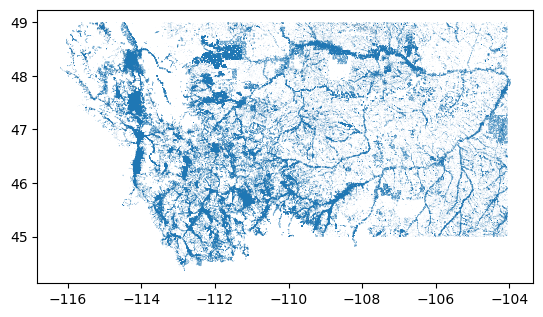

In [38]:
# plot shape info to map
gdfin1.plot()

In [39]:
# create output for Regulatory Area #1 dataframe
df = pd.DataFrame()

columnsList = ['in_SiteNativeID', 'geometry']
goutdf1 = pd.DataFrame(columns=columnsList, index=gdfin1.index)

goutdf1['in_SiteNativeID'] =  gdfin1["in_SiteNativeID"].astype(str)  #in_SiteNativeID needs to match source from above equivalent dataframe
goutdf1['geometry'] = gdfin1['in_Geometry']
goutdf1 = goutdf1.drop_duplicates().reset_index(drop=True)

# drop geometery from outdf
outdf = outdf.drop(['in_Geometry'], axis=1)

print(len(goutdf1))
goutdf1.head()

906451


,in_SiteNativeID,geometry
0,u57_76N 116396 00,POLYGON ((-115.01045983799997 47.8872449190000...
1,u26_76N 116398 00,POLYGON ((-115.01045983799997 47.8872449190000...
2,u18_76LJ 30002541,POLYGON ((-114.13193815699998 48.2983096420000...
3,u18_76LJ 30002543,POLYGON ((-114.13193815699998 48.2983096420000...
4,u18_76LJ 30002540,POLYGON ((-114.13193815699998 48.2983096420000...


## Export Data

In [40]:
outdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537246 entries, 0 to 1537245
Data columns (total 62 columns):
 #   Column                                        Non-Null Count    Dtype         
---  ------                                        --------------    -----         
 0   WaDEUUID                                      1537246 non-null  object        
 1   in_MethodUUID                                 1537246 non-null  object        
 2   in_VariableSpecificUUID                       1537246 non-null  object        
 3   in_OrganizationUUID                           1537246 non-null  object        
 4   in_GNISFeatureNameCV                          1537246 non-null  object        
 5   in_WaterQualityIndicatorCV                    1537246 non-null  object        
 6   in_WaterSourceName                            1537246 non-null  object        
 7   in_WaterSourceNativeID                        1537246 non-null  object        
 8   in_WaterSourceTypeCV                      

In [41]:
outdf

,WaDEUUID,in_MethodUUID,in_VariableSpecificUUID,in_OrganizationUUID,in_GNISFeatureNameCV,in_WaterQualityIndicatorCV,in_WaterSourceName,in_WaterSourceNativeID,in_WaterSourceTypeCV,in_CoordinateAccuracy,in_CoordinateMethodCV,in_County,in_EPSGCodeCV,in_GNISCodeCV,in_HUC12,in_HUC8,in_Latitude,in_Longitude,in_NHDNetworkStatusCV,in_NHDProductCV,in_PODorPOUSite,in_SiteName,in_SiteNativeID,in_SitePoint,in_SiteTypeCV,in_StateCV,in_USGSSiteID,in_AllocationApplicationDate,in_AllocationAssociatedConsumptiveUseSiteIDs,in_AllocationAssociatedWithdrawalSiteIDs,in_AllocationBasisCV,in_AllocationChangeApplicationIndicator,in_AllocationCommunityWaterSupplySystem,in_AllocationCropDutyAmount,in_AllocationExpirationDate,in_AllocationFlow_CFS,in_AllocationLegalStatusCV,in_AllocationNativeID,in_AllocationOwner,in_AllocationPriorityDate,in_AllocationSDWISIdentifierCV,in_AllocationTimeframeEnd,in_AllocationTimeframeStart,in_AllocationTypeCV,in_AllocationVolume_AF,in_BeneficialUseCategory,in_CommunityWaterSupplySystem,in_CropTypeCV,in_CustomerTypeCV,in_DataPublicationDate,in_DataPublicationDOI,in_ExemptOfVolumeFlowPriority,in_GeneratedPowerCapacityMW,in_IrrigatedAcreage,in_IrrigationMethodCV,in_LegacyAllocationIDs,in_OwnerClassificationCV,in_PopulationServed,in_PowerType,in_PrimaryBeneficialUseCategory,in_SDWISIdentifierCV,in_WaterAllocationNativeURL
0,d0,MTwr_M1,MTwr_V1,MTwr_O1,,Fresh,Fishtrap Creek,wadeId1,SURFACE,WaDE Blank,WaDE Blank,Sanders,4326,,,,47.90917,-115.19375,,,POD,,d2_76N 52615 00,,LIVESTOCK DIRECT FROM SOURCE,MT,,,,,,,,,,,ACTIVE,76N 52615 00,Usa Dept Of Agriculture Forest Service,1915-06-01,,09/30,06/01,STATEMENT OF CLAIM,,STOCK,,,,,,0,,,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
1,d1,MTwr_M1,MTwr_V1,MTwr_O1,,Fresh,Groundwater,wadeId2,GROUNDWATER,WaDE Blank,WaDE Blank,Lake,4326,,,,47.66730,-114.10262,,,POD,,d1_76LJ 30161212,,INDIVIDUAL WELL,MT,,,,,,,,,,0.27000,ACTIVE,76LJ 30161212,"Alvin Devore, Barbara Devore",2023-08-21,,12/31,01/01,DOMESTIC ALLOWANCE,,"LAWN AND GARDEN, DOMESTIC",,,,,,0,,0.50000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
2,d2,MTwr_M1,MTwr_V1,MTwr_O1,,Fresh,Groundwater,wadeId2,GROUNDWATER,WaDE Blank,WaDE Blank,Lake,4326,,,,47.63843,-114.20987,,,POD,,d1_76L 30160191,,INDIVIDUAL WELL,MT,,,,,,,,,,0.03000,ACTIVE,76L 30160191,"John B King, Mary E King",2023-02-02,,12/31,01/01,DOMESTIC ALLOWANCE,,"LAWN AND GARDEN, DOMESTIC",,,,,,0,,0.25000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
3,d3,MTwr_M1,MTwr_V1,MTwr_O1,,Fresh,Unnamed Tributary Of Dublin Gulch,wadeId3,SURFACE,WaDE Blank,WaDE Blank,Lake,4326,,,,47.46435,-114.12911,,,POD,,d7_76L 30144554,,LIVESTOCK DIRECT FROM SOURCE,MT,,,,,,,,,,,ACTIVE,76L 30144554,"Montana, State Of Dept Of Fish Wildlife Parks",1934-03-21,,12/31,01/01,STATEMENT OF CLAIM,,STOCK,,,,,,0,,,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
4,d4,MTwr_M1,MTwr_V1,MTwr_O1,,Fresh,Unnamed Tributary Of Dublin Gulch,wadeId3,SURFACE,WaDE Blank,WaDE Blank,Lake,4326,,,,47.46433,-114.10775,,,POD,,d6_76L 30144554,,LIVESTOCK DIRECT FROM SOURCE,MT,,,,,,,,,,,ACTIVE,76L 30144554,"Montana, State Of Dept Of Fish Wildlife Parks",1934-03-21,,12/31,01/01,STATEMENT OF CLAIM,,STOCK,,,,,,0,,,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537241,u955705,MTwr_M1,MTwr_V1,MTwr_O1,,,Unnamed Tributary Of Dry Creek,wadeId283,SURFACE,WaDE Blank,Centroid of Area,Lake,4326,,,,47.37929,-114.12614,,,POU,,u1095_76L 166604 00,,,MT,,,,,,,,,,50.00000,ACTIVE,76L 166604 00,Flathead Joint Board Of Control,NaT,,10/31,04/01,STATEMENT OF CLAIM,,IRRIGATION,,,,,,0,,138990.00000,,,,,,,,https://wrqsproxy.dnrc.mt.gov/Report?/WRQS/WRD...
1537242,u955706,MTwr_M1,MTwr_V1,MTwr_O1,,,Cold Creek,wadeId2015,SURFACE,WaDE Blank,Centroid of Area,Lake,4326,,,,47.

In [42]:
# Export the output dataframe
# change output name / abbreviation to match native state provdier and wade data type 
outdf.to_csv('RawInputData/Pwr_Main.zip', compression=dict(method='zip', archive_name='Pwr_Main.csv'), index=False)  # The output, save as a zip
goutdf1.to_csv('RawInputData/P_Geometry.zip', compression=dict(method='zip', archive_name='P_Geometry.csv'), index=False)  # The output geometry.